In [1]:
import copy

In [2]:
import datetime
from pathlib import Path

import cartopy
import numpy as np
import pytz

In [3]:
import rasterio
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from rasterio.windows import Window

import a301_lib  # noqa
from sat_lib.landsat.landsat_metadata import landsat_metadata
from sat_lib.landsat.toa_reflectance import calc_reflc_8

pacific = pytz.timezone("US/Pacific")
date = datetime.datetime.today().astimezone(pacific)
print(f"written on {date}")

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init
written on 2020-11-15 20:27:18.630488-08:00


(rasterio_3bands)=
# Rasterio: reading bands 3,4 and 5

In this notebook I clip bands 3, 4 and 5 to a 600 row by
400 column raster and write them out in a new tiff file
called vancouver_345_refl.tiff

What to look for:

* Reading the original transform and crs from the B4.TIF file
* Finding the upper-left hand corner of the 600, 400 subscene
* Writing out the new 3-band geotiff with new tags

## Get bands 3, 4, 5 fullsize (green, red, near-ir)

This cells finds the TIF files downloaded by {ref}`landsat1` and
saves the paths as band3_bigfile, band4_bigfile, band5_bigfile

In [4]:
notebook_dir = Path().resolve().parent
print(notebook_dir)

/home/phil/repos/a301_2020/notebooks


In [5]:
landsat_dir = notebook_dir / "week9/landsat_scenes"
print(landsat_dir)
band3_bigfile = list(landsat_dir.glob("**/*B3.TIF"))[0]
print(band3_bigfile)
band4_bigfile = list(landsat_dir.glob("**/*B4.TIF"))[0]
print(band4_bigfile)
band5_bigfile = list(landsat_dir.glob("**/*B5.TIF"))[0]
print(band5_bigfile)
mtl_file = (notebook_dir / "week9/landsat_scenes").glob("**/*MTL.txt")
mtl_file = list(mtl_file)[0]
print(mtl_file)

/home/phil/repos/a301_2020/notebooks/week9/landsat_scenes
/home/phil/repos/a301_2020/notebooks/week9/landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_B3.TIF
/home/phil/repos/a301_2020/notebooks/week9/landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF
/home/phil/repos/a301_2020/notebooks/week9/landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_B5.TIF
/home/phil/repos/a301_2020/notebooks/week9/landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_MTL.txt


## Now use rasterio to read in your affine transform, and profile

Using band4_bigfile (arbitrary, could be any of the 3 tif files)

In [6]:
with rasterio.open(band4_bigfile) as raster:
    big_transform = raster.transform
    big_profile = raster.profile
print(big_transform)
print(big_profile)

| 30.00, 0.00, 397185.00|
| 0.00,-30.00, 5531415.00|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7851, 'height': 7961, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 397185.0,
       0.0, -30.0, 5531415.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


* Note that cartopy needs its own version of the crs -- it doesn't understand rasterio's format

In [7]:
crs = big_profile["crs"]
cartopy_crs = cartopy.crs.epsg(crs.to_epsg())
print(f"crs for cartopy: {cartopy_crs}")
print(f"crs for rasterio: {crs}")

crs for cartopy: _EPSGProjection(32610)
crs for rasterio: EPSG:32610


In [8]:
print(big_transform)

| 30.00, 0.00, 397185.00|
| 0.00,-30.00, 5531415.00|
| 0.00, 0.00, 1.00|


*  Read the affine transform we want from the small_file.tiff we created in the
   in the {ref}`image_zoom` notebook.

In [9]:
week10_scene = notebook_dir / "week10/small_file.tiff"
with rasterio.open(week10_scene) as raster:
    small_transform = raster.transform
    small_profile = raster.profile
print(small_transform)

| 30.00, 0.00, 479085.00|
| 0.00,-30.00, 5471475.00|
| 0.00, 0.00, 1.00|


In [10]:
print(small_profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 400, 'height': 600, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 479085.0,
       0.0, -30.0, 5471475.0), 'tiled': False, 'interleave': 'band'}


## Finding the upper left corner in UTM10 coords

How do we find this small rectangle on the band4_bigfile raster?

We know the UTM zone 10 coordinates of the upper left corner, so we just need the row
and column for that on the big raster.  I use the two transforms, small_transform and
big_transform to first find the ul_x and ul_y coords of the upper left corner  in
UTM10 coords, and then transform that point into a row and column on the big image.
That tellse me where I need to make my cut for the three big images.

In [11]:
ul_x, ul_y = small_transform * (0, 0)
print(f"{ul_x=},{ul_y=:5.21}")

ul_x=479085.0,ul_y=5471475.0


In [12]:
ul_col, ul_row = ~big_transform * (ul_x, ul_y)
print(f"{ul_col=}, {ul_row=}")
small_width = small_profile["width"]
small_height = small_profile["height"]
print(f"{small_width=},{small_height=}")

ul_col=2730.0, ul_row=1998.0
small_width=400,small_height=600


## Reading from a rasterio window

Now I'm ready to form a rasterio "window" that just gives me
the part of the big scenes I need to read in

In [13]:
small_window = Window(ul_col, ul_row, small_width, small_height)

* Here is how to find the lower right corner by counting over and down from (0,0)

In [14]:
lr_x, lr_y = small_transform * (small_width, small_height)
print(f"{lr_x=},{lr_y=}")

lr_x=491085.0,lr_y=5453475.0


* Define a subscene window and a transform


I can use rasterio to read only the small_window part of the files.  I do that
for each of the bands below.

## Calculate the reflectivites

In [15]:
refl_dict = dict()
metadata = landsat_metadata(mtl_file)
for bandnum, filepath in zip([3, 4, 5], [band3_bigfile, band4_bigfile, band5_bigfile]):
    with rasterio.open(filepath) as src:
        counts = src.read(1, window=small_window)
        refl_vals = calc_reflc_8(counts, bandnum, metadata)
        refl_dict[bandnum] = refl_vals
print(refl_vals)

Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43
[[0.0166037  0.01612276 0.0165808  ... 0.23295562 0.25157466 0.25695655]
 [0.01687852 0.01639758 0.01680981 ... 0.25730008 0.25736878 0.2659798 ]
 [0.01687852 0.01632888 0.01630598 ... 0.26215523 0.2673081  0.26884251]
 ...
 [0.02439026 0.02390933 0.02331388 ... 0.22345143 0.22757373 0.23114639]
 [0.02480249 0.02409254 0.02368031 ... 0.24220789 0.23726113 0.26717069]
 [0.02443606 0.02406964 0.02406964 ... 0.23467324 0.23249759 0.23506257]]


*  In the next cell calculate the ndvi

In [16]:
ndvi = (refl_dict[5] - refl_dict[4]) / (refl_dict[5] + refl_dict[4])
print(f"{ndvi.shape=}")

ndvi.shape=(600, 400)


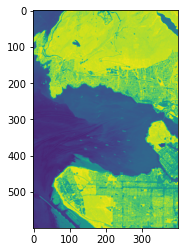

In [17]:
plt.imshow(ndvi)

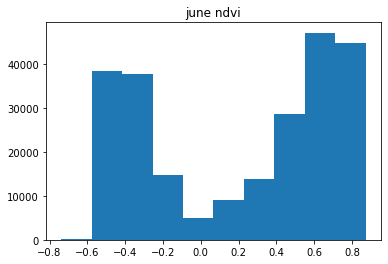

In [18]:
# Save it in a variable called ndvi
plt.hist(ndvi[~np.isnan(ndvi)].flat)
plt.title("june ndvi")
plt.savefig("june_ndvi.png")

* In the next cell I plot a mapped ndvi image with a red dot in the
  ul corner and a white dot in the lr corner to test my coordinate transformation.
  I keep the crs from the big file, since that hasn't changed from UTM10N.

## Put the image on a map

In [19]:
ul_x, lr_x, lr_y, ul_y

(479085.0, 491085.0, 5453475.0, 5471475.0)

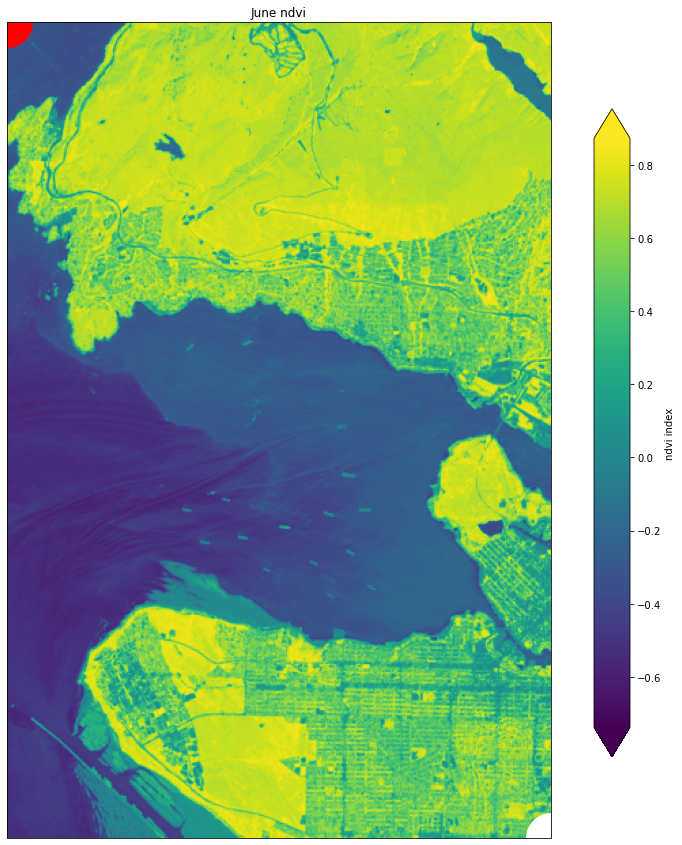

In [20]:
vmin = 0.0
vmax = 0.8
the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)
palette = "viridis"
pal = copy.copy(plt.get_cmap(palette))
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("w")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
fig, ax = plt.subplots(1, 1, figsize=[10, 15], subplot_kw={"projection": cartopy_crs})
#
# limit cartopy to only show the small_window extent
#
extent = [ul_x, lr_x, lr_y, ul_y]
col = ax.imshow(ndvi, origin="upper", extent=extent, transform=cartopy_crs)
ax.plot(ul_x, ul_y, "ro", markersize=50)
ax.plot(lr_x, lr_y, "wo", markersize=50)
ax.set(title="June ndvi")
cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])
cbar = ax.figure.colorbar(col, extend="both", cax=cbar_ax, orientation="vertical")
cbar.set_label("ndvi index")

## write out the bands 3, 4, 5 as a new geotiff

Now I'm going to write out a new 3 channel tiff.  I can add extra tags to the
tiff to remind me what I did.  I'm writing out the names of the original big tiffs
I used, the names of the channels and some comments about the time and the name
of this notebook.  As demonstrated in class, I can read these tags using `rio insp` from
a terminal prompt.

In [21]:
week10_dir = notebook_dir / "week10"
b3, b4, b5 = refl_dict[3], refl_dict[4], refl_dict[5]
channels = np.empty([3, b3.shape[0], b4.shape[1]], dtype=b4.dtype)
tif_filename = week10_dir / "vancouver_345_refl.tiff"
num_chans, height, width = channels.shape

for index, image in enumerate([b3, b4, b5]):
    channels[index, :, :] = image[...]

with rasterio.open(
    tif_filename,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=num_chans,
    dtype=channels.dtype,
    crs=big_profile["crs"],
    transform=small_transform,
    nodata=-9999.0,
) as dst:
    dst.write(channels)
    chan_tags = ["LC8_Band3_toa_refl", "LC8_Band4_toa_refl", "LC8_Band5_toa_refl"]
    dst.update_tags(
        band3_file=band3_bigfile.name,
        band4_file=band4_bigfile.name,
        band5_file=band5_bigfile.name,
        history="written by ndvi_rasterio.md",
        written_on=str(datetime.date.today()),
    )
    for index, chan_name in enumerate(chan_tags):
        dst.update_tags(index + 1, name=chan_name)
        dst.update_tags(index + 1, valid_range="0,1")

## Read the new tif_file back in to check

In [22]:
with rasterio.open(tif_filename) as raster:
    transform = raster.transform
    profile = raster.profile
print(f"{profile=}")
print(f"{transform=}")

profile={'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 400, 'height': 600, 'count': 3, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 479085.0,
       0.0, -30.0, 5471475.0), 'tiled': False, 'interleave': 'pixel'}
transform=Affine(30.0, 0.0, 479085.0,
       0.0, -30.0, 5471475.0)
